In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/CondNet')

In [3]:
from tqdm.notebook import tqdm

import importlib
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor, Size
from torch import autograd
from torch.nn import Module
from typing import Optional
from torch.nn import functional as F

import img_utils as iu
import loss_iter
import CondNet

In [4]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

In [5]:
importlib.reload(iu)
iu.gen_images(20000)

In [6]:
class ReductionBlock(nn.Module):

    def __init__(self, in_channels):
        super(ReductionBlock, self).__init__()
        self.in_channels = in_channels
        self.net = nn.Sequential(
            nn.Conv2d(self.in_channels, 32, kernel_size=(4, 4)),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Conv2d(32, 48, kernel_size=(4, 4)),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Conv2d(48, 64, kernel_size=(4, 4)),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Conv2d(64, 96, kernel_size=(4, 4)),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Upsample(scale_factor=64)
        )

    def forward(self, x):
        return self.net(x)

In [7]:
class MainBlock(nn.Module):
    
    def __init__(self, in_channels, kernel_size):
        super(MainBlock, self).__init__()
        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.reduction_block = ReductionBlock(self.in_channels)
        self.batch_norm = nn.BatchNorm2d(self.in_channels)
        
        if self.kernel_size % 2 == 0:
            self.zero_pad = nn.ZeroPad2d(padding=(3, 0, 3, 0))
            self.conv_layer = nn.Conv2d(self.in_channels + 96, 64, kernel_size=self.kernel_size, padding=0)
        else:
            self.conv_layer = nn.Conv2d(self.in_channels + 96, 64, kernel_size=self.kernel_size, padding=self.kernel_size // 2)
    def forward(self, x):
        x = self.batch_norm(x)
        reduced_x = self.reduction_block(x)
        # print(reduced_x.shape, x.shape)
        x = torch.cat((x, reduced_x), dim=1)
        if self.kernel_size % 2 == 0:
            x = self.zero_pad(x)
        x = self.conv_layer(x)
        x_mean = x.mean()
        ones = torch.ones(x.shape)
        if torch.cuda.is_available():
          ones = ones.cuda()
        x = torch.cat((x, x_mean * ones), dim=1)
        return x

In [8]:
class CondNet(nn.Module):

    def __init__(self, in_channels, n_class=3):
        super(CondNet, self).__init__()
        self.in_channels = in_channels
        self.n_class = n_class
        self.net = nn.Sequential(
            MainBlock(self.in_channels, 3),
            MainBlock(128, 4),
            MainBlock(128, 5)
        )

        self.cond_linear = nn.Sequential(
            nn.Linear(128, 64),
            nn.ELU(),
            nn.Linear(64, 64),
            nn.ELU(),
            nn.Linear(64, 1)
        )

        self.cluster_linear = nn.Sequential(
            nn.Linear(128, 64),
            nn.ELU(),
            nn.Linear(64, 64),
            nn.ELU(),
            nn.Linear(64, 2)
        )

        self.seg_linear = nn.Sequential(
            nn.Linear(128, 64),
            nn.ELU(),
            nn.Linear(64, 64),
            nn.ELU(),
            nn.Linear(64, 4),
            nn.Softmax2d(),
        )

    def forward(self, x):
        x = self.net(x)
        x = x.permute(0, 2, 3, 1)
        beta = self.cond_linear(x).squeeze(3)
        clust = self.cluster_linear(x)
        seg = self.seg_linear(x).permute(0, 3, 1, 2)
        return beta, clust, seg

In [9]:
torch.manual_seed(0)
np.random.seed(0)

test_net = CondNet(3)
test_net.cuda()

opt1 = optim.Adam(test_net.parameters(), lr=5*10**(-4))

In [10]:
importlib.reload(loss_iter)
loss_func = loss_iter.CondLoss(loss_function=nn.CrossEntropyLoss(reduce=False), q_min=0.2, supression=20, cond_weight=0.3, cuda=True)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [11]:
ds = iu.ImageDataset('')

In [12]:
dataloader = torch.utils.data.DataLoader(ds, batch_size=100, shuffle=False)#, collate_fn=lambda batch: [(dp[0], dp[1], dp[2]) for dp in batch])

In [56]:
import gc

gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()


In [ ]:


test_net.cuda()
test_net.train()
for i, (data, mask, matrix) in enumerate(dataloader):
  if (i < 9):
    print(f"i is {i}")
    data = data.cuda().float()
    mask = mask.cuda().squeeze(1)
    matrix = matrix.cuda().float()
    with autograd.detect_anomaly():
      opt1.zero_grad()
      beta, test_x, segmentation = test_net(data)
      test_matrix = matrix.reshape(matrix.shape[0], matrix.shape[1], -1)
      test_out = nn.Sigmoid()(beta)
      test_beta = test_out.reshape(test_out.shape[0], -1)
      print(torch.sum(test_beta < -1), torch.sum(test_beta > 1))
      test_q = loss_func.atanh(test_beta) ** 2 + loss_func.q_min
      print(f"q not nan: {torch.sum(torch.isnan(test_q))}")
      print(f"q max: {torch.max(test_q - loss_func.q_min, dim=1)}")
      test_noise = (torch.sum(test_matrix, dim=1) < 1).float()
      print(f"Noise vertices: {torch.sum(test_noise, dim=1)}")
      print(f"test_noise : {torch.sum((1 - test_noise) * (test_q - loss_func.q_min), dim=1)}")
      print(mask.shape, segmentation.shape)
      temp_general_loss = loss_func.general_loss(test_noise, test_q, segmentation, mask)
      temp_background_loss = loss_func.background_loss(test_beta, test_matrix, test_noise, test_matrix.shape[1])
      temp_potential_loss = loss_func.potential_loss(test_x.reshape(10, -1, 2), test_q, test_matrix, 64, 64, test_matrix.shape[1])
      print(f"General loss: {temp_general_loss}")
      print(f"Background loss: {temp_background_loss}")
      print(f"Potential loss: {temp_potential_loss}")
      print(f"Overall loss: {(temp_general_loss + loss_func.cond_weight * (temp_background_loss + temp_potential_loss)).mean()}")
      # print(test_noise.shape)
      # print(test_noise)
      # print(torch.sum(torch.eq(test_noise, 0)), torch.sum(torch.isnan(test_out)), torch.sum(torch.isnan(output[1])))
      if i < 8:
        curr_loss = loss_func(test_x, test_out, matrix, segmentation, mask)
        print(torch.sum(torch.isnan(curr_loss)))
        print(curr_loss.item())
        curr_loss.backward()
        opt1.step()

In [ ]:
n_epochs = 20
# torch.autograd.set_detect_anomaly = True
loss_vs_epoch = []
test_net.float()
test_net.train()
sigmoid = nn.Sigmoid()
for epoch in tqdm(range(n_epochs)):
    temp_loss = 0
    for i, (data, mask, matrix) in enumerate(dataloader):
        opt1.zero_grad()
        data = data.cuda().float()
        mask = mask.cuda().squeeze(1)
        matrix = matrix.cuda().float()
        try:
          with autograd.detect_anomaly():
            output = test_net(data)
            curr_loss = loss_func(output[1], sigmoid(output[0]), matrix, output[2], mask)
            curr_loss.backward()
            opt1.step()
        except Exception as e:
          print(i, curr_loss)
          print(e)
          raise
        temp_loss += curr_loss.item() * data.size(0)
    loss_vs_epoch.append(temp_loss / len(dataloader.sampler))
    print(f"Epoch: {epoch}, Loss: {loss_vs_epoch[-1]}")
    torch.save(test_net.state_dict(), 'net_my_fcn.pt')

torch.save(test_net.state_dict(), '/content/drive/My Drive/Colab Notebooks/CondNet/net_my_fcn.pt')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  from ipykernel import kernelapp as app


Epoch: 0, Loss: 0.4597792334854603
Epoch: 1, Loss: 0.30465938985347746
Epoch: 2, Loss: 0.3040757283568382
Epoch: 3, Loss: 0.3035170328617096
Epoch: 4, Loss: 0.3032880483567715
Epoch: 5, Loss: 0.3031859156489372
Epoch: 6, Loss: 0.30307984113693237
Epoch: 7, Loss: 0.3029605385661125
Epoch: 8, Loss: 0.30285963222384454
Epoch: 9, Loss: 0.3027888610959053
Epoch: 10, Loss: 0.30273773699998857


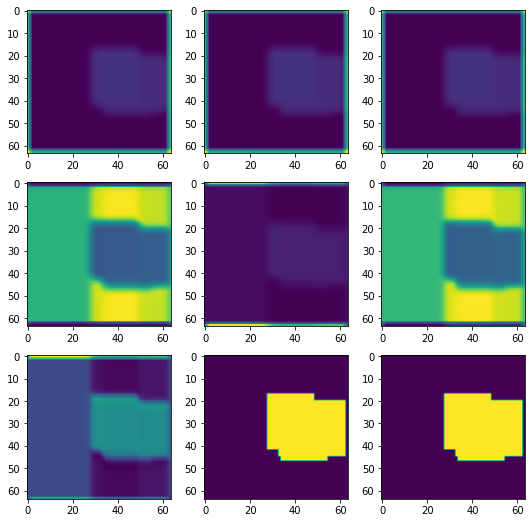

In [31]:
item = 134

data, mask, _ = ds[item]

data = data.unsqueeze(0).cuda().float()
test_net.eval()
test_out = test_net(data)


fig, ax = plt.subplots(3, 3, figsize=(9,9))



ax[0, 0].imshow(test_out[0][0, :, :].cpu().data.numpy())
ax[0, 1].imshow(test_out[0][0, :, :].cpu().data.numpy())
ax[0, 2].imshow(test_out[0][0, :, :].cpu().data.numpy())

ax[1, 0].imshow((test_out[2][0, 0, :, :]).cpu().data.numpy())
ax[1, 1].imshow((test_out[2][0, 1, :, :]).cpu().data.numpy())
ax[1, 2].imshow((test_out[2][0, 2, :, :]).cpu().data.numpy())

ax[2, 0].imshow((test_out[2][0, 3, :, :]).cpu().data.numpy())
ax[2, 1].imshow(mask[0, :, :].cpu().data.numpy())
ax[2, 2].imshow(mask[0, :, :].cpu().data.numpy())

plt.show()